In [1]:
%matplotlib inline
import geopandas
import rasterio
import rasterio.features
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.morphology as morphology
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy.ndimage import binary_dilation
import statsmodels.distributions.empirical_distribution as edf

## Parameters to set

In [2]:
# Make sure both of these are in a UTM projection!
# For north island, we use EPSG:32760
positives_name = 'large_landslidesV2_32760.shp'
boundary_name = 'boundary_32760.shp'

# This parameter sets the resolution of the analysis, making this parameter
# smaller will allow shapes to fit in more tightly, but will exponentially
# slow down the analysis
resolution = 100.0

## Functions

In [3]:
def convert_to_raster(polygons,out_name,bounds,resolution=100.0,cache_max=128e6):
    # Get shape/origin
    origin = (bounds['minx'],bounds['maxy'])
    nrow = int(np.ceil((bounds['maxy']-bounds['miny'])/resolution))
    ncol = int(np.ceil((bounds['maxx']-bounds['minx'])/resolution))

    # Set transform and profile
    transform = rasterio.Affine(resolution,0.0,float(origin[0]),0,-resolution,float(origin[1]))
    profile = rasterio.profiles.Profile()
    profile.update(driver='GTiff',dtype='uint8',width=ncol,height=nrow,
                   count=1,crs=str(polygons.crs),transform=transform,tiled=False,compress='lzw',interleave='band')
    
    # Rasterize
    with rasterio.Env(CPL_DEBUG=True, GDAL_CACHEMAX=cache_max):
        rasterized = rasterio.features.rasterize(
            [(x.geometry, 1) for i, x in polygons.iterrows()],
            out_shape=(nrow, ncol),
            transform=transform,
            fill=0,
            all_touched=True,
            dtype=rasterio.uint8)

        # Write to file
        rasterized[rasterized < 1] = 0
        with rasterio.open(out_name, 'w', **profile) as out:
            out.write_band(1, rasterized)

    print(f'{out_name} done!')
    return out_name

## Convert polygons to rasters

In [4]:
# Read in data
positives = geopandas.read_file(positives_name)
study_area = geopandas.read_file(boundary_name)

# Compute shared bounding box
names = ['minx', 'miny', 'maxx', 'maxy']
pos_bounds = {b:int(round(a)) for a,b in zip(positives.total_bounds,names)}
area_bounds = {b:int(round(a)) for a,b in zip(study_area.total_bounds,names)}

# Convert to rasters and save
bounds = {}
for n in names:
    f = min if 'min' in n else max
    bounds[n] = f(pos_bounds[n],area_bounds[n])

pos_name = convert_to_raster(positives,'positives.tif',bounds,resolution=resolution,cache_max=512e6)
area_name = convert_to_raster(study_area,'study_area.tif',bounds,resolution=resolution,cache_max=512e6)

positives.tif done!
study_area.tif done!


## Generate distributions

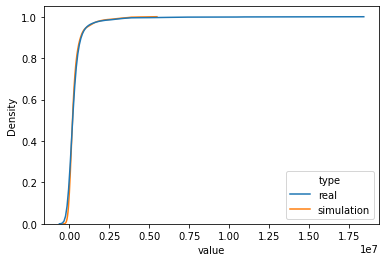

In [5]:
# Create cumulative density function sampling function
real = list(positives.area) + [0]
ecdf = edf.ECDF(real)
ecdfInv = edf.monotone_fn_inverter(ecdf, real)

# Create n simulated samples of areas
n = len(real)
rns = np.random.uniform(0.001,1,n)
simulation = ecdfInv(rns)

# Save areas and radii to csv
df = pd.DataFrame({'area':simulation})
df['radius'] = np.sqrt((df['area'])/np.pi)
df.to_csv('radii.csv',index=False)

# Plot area distributions
real_df = pd.DataFrame({'value':real,'type':'real'})
simulation_df = pd.DataFrame({'value':simulation,'type':'simulation'})
compare = real_df.append(simulation_df,ignore_index=True)
sns.kdeplot(data=compare,x='value',hue='type',cumulative=True,common_norm=False)
plt.show()

## Identify valid points

In [6]:
# Read rasters created in previous step
pos_name = 'positives.tif'
area_name = 'study_area.tif'
with rasterio.open(pos_name) as r:
    pos_ras = r.read(1)
    profile = r.profile
    transform = r.transform
    crs = str(r.crs)

pos_ras_dialated = binary_dilation(pos_ras,morphology.square(3))

with rasterio.open(area_name) as r:
    area_ras = r.read(1)

xstep, _, xstart, _, ystep, ystart, *_ = list(transform)

In [7]:
# Load radii data
df = pd.read_csv('radii.csv')
df[['row','column']] = 0

# # OR create synthetic data
# df = pd.DataFrame(columns=['row','column','radius'])
# df['radius'] = np.arange(1000,5000,1000)

# Calculate pixel (cell) radius and sort
df['radius_cell'] = df['radius'].divide(xstep).apply(np.ceil).astype(int)
df = df.sort_values('radius',ascending=False).reset_index(drop=True)

# Create emtpy raster to server as canvas
nrow,ncol = area_ras.shape
array = np.zeros(area_ras.shape)
array[(pos_ras==1)|(area_ras==0)] = 1

# Get row/column location
irow = df.columns.get_loc('row')
icol = df.columns.get_loc('column')

# Search raster iteratively for valid locations
for i,r in tqdm(df.iterrows(),total=df.shape[0]):
    radius = int(r['radius_cell'])
    circle = morphology.disk(radius)
    intersects = True
    while intersects:
        possible = np.where(array[radius:-radius,radius:-radius]==0)
        lrow, lcol = [np.random.choice(x)+radius for x in possible]
        window = (slice(lrow-radius,lrow+radius+1), slice(lcol-radius,lcol+radius+1))
        added = circle+array[window]
        intersects = np.any(added==2)

    array[window] = circle
    df.iloc[i,irow] = lrow
    df.iloc[i,icol] = lcol

df.to_csv('points.csv',index=False)

  0%|          | 0/1058 [00:00<?, ?it/s]

In [8]:
# Get transform data and convert form row/column to x/y
df = pd.read_csv('points.csv')
df['x'] = xstart + (df['column']*xstep) + (xstep/2)
df['y'] = ystart + (df['row']*ystep) + (ystep/2)

# Write output shapefile
gdf = df.copy()
gdf = geopandas.GeoDataFrame(gdf, geometry=geopandas.points_from_xy(gdf.x, gdf.y),crs=crs)
gdf.drop(['x','y','row','column','radius_cell'],axis=1,inplace=True)
gdf['radius'] = gdf['radius'].astype('int64')

# Buffer
negatives = gdf.copy()
negatives.geometry = negatives.apply(lambda x: x.geometry.buffer(x.radius), axis=1)
negatives.to_file('negatives.shp')

In [9]:
# Write output combination raster for error checking
profile.update(nodata=0)
with rasterio.open('all.tif', 'w', **profile) as out:
    out.write_band(1, array)